In [2]:
pip install py_mesa_reader-master.zip

Processing ./py_mesa_reader-master.zip
  Preparing metadata (setup.py) ... done
  Created wheel for mesa-reader: filename=mesa_reader-0.3.0-py3-none-any.whl size=10403 sha256=2640b517c0144a035fff2a914c98e014a871d59992100438f2e21b7741863b1a
  Stored in directory: /home/elainaplonis/.cache/pip/wheels/08/66/0e/d64316f98a36c54e2ae4c0a4e9301061fdab769cc4a6562b85
Successfully built mesa-reader
  Attempting uninstall: mesa-reader
    Found existing installation: mesa-reader 0.3.0
    Uninstalling mesa-reader-0.3.0:
      Successfully uninstalled mesa-reader-0.3.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
## Imports and setup

from os.path import join, abspath, dirname

import numpy as np
import matplotlib.pyplot as plt

import mesa_reader as mr
from composition_blend import blend_comps, make_composition_file
plt.style.use('custom.mplstyle')

WOLF_MODELS_DIR = abspath(join('.', 'wolf_2013_models'))
model_1p0 = mr.MesaData(join(WOLF_MODELS_DIR, '1.0Msun_Tc_3e7_init.mod'))
model_1p3 = mr.MesaData(join(WOLF_MODELS_DIR, '1.3Msun_Tc_3e7_init.mod'))

def texify(iso):
    "Create a TeX-friendly version of an isotope string."
    element = ''.join([i for i in iso if not i.isdigit()])
    mass_number = ''.join([i for i in iso if i.isdigit()])
    return r"$^{" + str(mass_number) + r"}\mathrm{" + f"{element.title()}" + r"}$"
    

# Extracting Source compositions
In this example, we'll extract four compositions from a $1.0~M_\odot$ CO WD model. They will correspond to
- Surface
- Middle of the He layer
- Middle of the outer core (where CO was made by shell He burning)
- Center of the inner core (where CO was made by convective He core burning)

We visualize this with an abundance plot and then eyeball some locations where we want to extract the compositions.

Finally, we build up the appropriate 1D structured arrays to store the compositions. Each has columns that are named for the isotopes and has values that are the mass fractions. These will eventually be funneled into the `blend_comps` function.

['h1', 'he3', 'he4', 'c12', 'c13', 'n13', 'n14', 'n15', 'o14', 'o15', 'o16', 'o17', 'o18', 'f17', 'f18', 'f19', 'ne18', 'ne19', 'ne20', 'ne22', 'mg22', 'mg24', 'mg26', 'fe56']


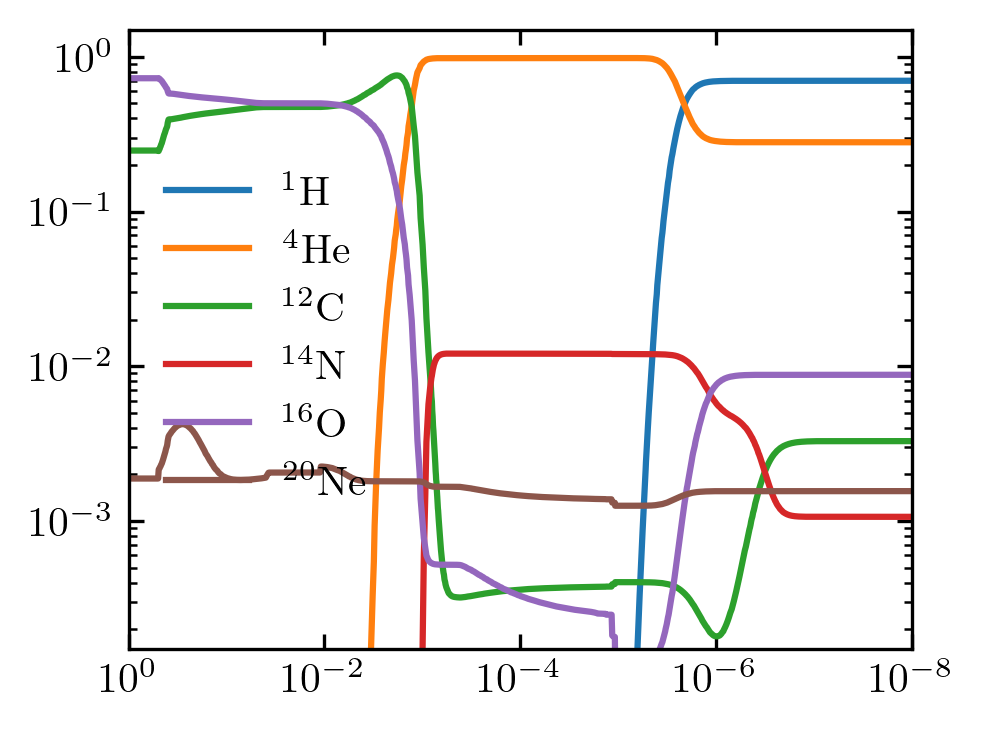

In [6]:
fig, ax = plt.subplots()
xqs = np.cumsum(model_1p0.dq)
for iso in ['h1', 'he4', 'c12', 'n14', 'o16', 'ne20']:
    ax.loglog(xqs, model_1p0.data(iso), label=texify(iso))

ax.set_xlim(1, 1e-8)
ax.set_ylim(1.5e-4, 1.5)

ax.legend(loc='best')

# eyeballed from plot
sample_xqs = [1e-8, 1e-4, 2e-2, 1]
core_shell_xq = 0.45
core_shell_dq = 0.1
core_shell_xm = core_shell_xq * model_1p0.header('M/Msun')
core_shell_dm = core_shell_dq * model_1p0.header('M/Msun')


isos = model_1p0.bulk_names[model_1p0.bulk_names.index('h1'):]
print(isos)
# create composition arrays for each sample location
dt = np.dtype([(iso, float) for iso in isos])
comps = []
for xq in sample_xqs:
    this_comp = np.zeros(1, dtype=dt)
    # find location in model closest to xq
    idx = np.argmin(np.abs(xqs - xq))
    for iso in isos:
        this_comp[iso] = model_1p0.data(iso)[idx]
    comps.append(this_comp)


# Identifying mass coordinates for the layer transitions
We look at a ONe 1.30 $M_\odot$ model to see where the equivalent zones (inner core, outer core, He layer, and surface) are located. We'll extract mass coordinates for the transition points as well as the thicknesses of the layers in q-space in a subsequent cell.

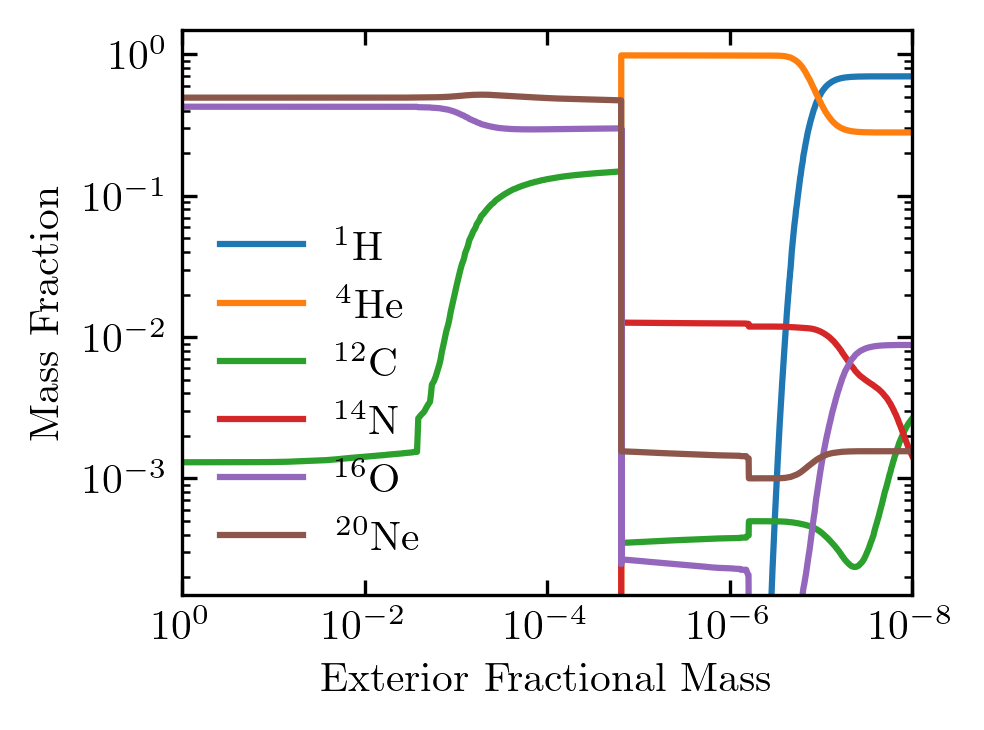

In [7]:
fig, ax = plt.subplots()
xqs = np.cumsum(model_1p3.dq)
for iso in ['h1', 'he4', 'c12', 'n14', 'o16', 'ne20']:
    ax.loglog(xqs, model_1p3.data(iso), label=texify(iso))

ax.set_xlim(1e0, 1e-8)
ax.set_ylim(1.5e-4, 1.5)
ax.set_xlabel(r"Exterior Fractional Mass")
ax.set_ylabel(r"Mass Fraction")

ax.legend(loc='best')

# Precisely defining locations and thicknesses of transitions
This is probably overengineered, since the `wd_builder` routines ended up causing some horrible mixing between the layers. But, this is at least somewhat physically motivated by trying to mirror what an existing massive model did. We identify the regions of interest by using thresholds (hard-coded for now) for where we transition from H to He and then from He to metals. For the inner core to outer core, we rely on the actual mass coordinates (not fractional coordinates) from the 1.0 $M_\odot$ model. This is because the core should have been formed as a less massive WD, and then it grew through helium accretion and/or mergers. Thus, the inner core should be very similar to that of a more conventional CO WD.

Again, this attention to detail on the outer layers seems to have been wasted, at least for the first test model, as a bunch of nasty stair-stepping occurred. I'm guessing some sporading convection happened during the initial relaxation process. Perhaps we'd be better off just doing hard transitions without all of this fancy tanh stuff, and then just rely on a period of elemental diffusion to smooth things out. Then again... sharp transitions may make the diffusion solver grumpy. This is somthing to test in the future.

In [8]:
# boundary between core from core burning and core from shell burning
core_shell_xq = core_shell_xm / model_1p3.header('M/Msun')
core_shell_dq = core_shell_dm / model_1p3.header('M/Msun')
# boundary between he layer and metal "core" (really with the core from shell
# burning)
metal_core_xq = -1
metal_core_dq = 0

# boundary between he layer and hydrogren envelope
he_core_xq = -1
he_core_dq = 0

# determine the h-he boundary and he-core boundary for the 1.3 Msun model
xqs = np.cumsum(model_1p3.dq)
for k, (xq, h1, he4) in enumerate(zip(xqs, model_1p3.h1, model_1p3.he4)):
    # account for transition zone between h-rich and he-rich layers
    if 1e-3 * model_1p3.h1[0] < h1 < 0.98 * model_1p3.h1[0] and he_core_xq < 0:
        he_core_dq += model_1p3.dq[k]
    if h1 < 0.01 and he_core_xq < 0:
        he_core_xq = xq
    # account for transition zone between he-rich and metal-rich layers
    if he_core_xq > 0 and 0.05 < he4 / max(model_1p3.he4) < 0.95:
        metal_core_dq += model_1p3.dq[k]
    if he4 < 0.01 and metal_core_xq < 0:
        metal_core_xq = xq
    if metal_core_xq > 0 and he4 < 1e-4:
        break
print(f"Core/shell boundary at xq = {core_shell_xq:.2e} with dq = {core_shell_dq:.2e}")
print(f"Metal core at xq = {metal_core_xq:.2e} with dq = {metal_core_dq:.2e}")
print(f"He core at xq = {he_core_xq:.2e} with dq = {he_core_dq:.2e}")


Core/shell boundary at xq = 3.46e-01 with dq = 7.68e-02
Metal core at xq = 1.54e-05 with dq = 5.89e-14
He core at xq = 2.46e-07 with dq = 1.93e-07


# Building the composition array
Below, we put together the work from above: the four compositions and the three sets of external fractional mass coordinates and transitions widths. We build up the tuple of "configurations" (composition array, external fractional mass coordinates, and transitions widths), and feed it all in to the `blend_comps` function. We used the same nuclear network that the source 1.30 $M_\odot$ model used so there is no isotope funny business. It'd probably be a good idea to keep consistency from this stage to whatever we use in `wd_builder`. The nuclear networks we use here may not be the same as what are present in the `make_CO_wd` and `make_ONe_wd` test cases, though.

After building the composition array and writing it to a file with the desired structure, we also visualize it to make sure it looks reasonable.

In [9]:
model_1p3.header_data

{'year_month_day_when_created': 20121128,
 'M/Msun': 1.2999876763156197,
 'model_number': 600,
 'star_age': 17.110012497127904,
 'initial_z': 0.02,
 'n_shells': 2034,
 'net_name': 'cno_extras_o18_to_mg26_plus_fe56.net',
 'species': 24,
 'tau_factor': 30.0}

(0.00015, 1.5)

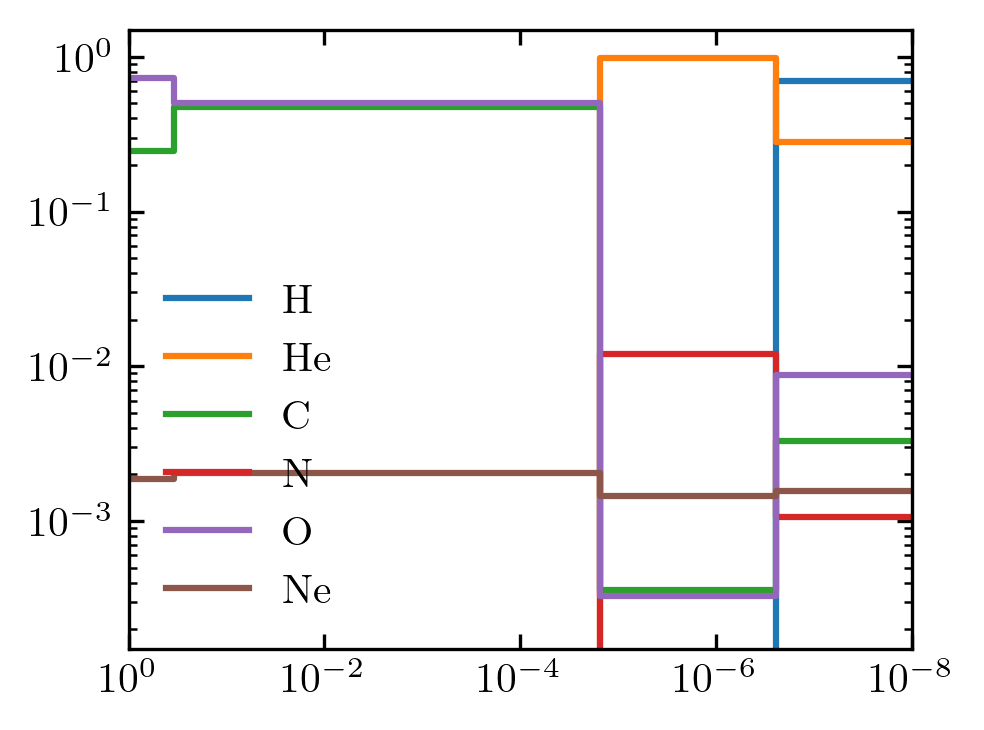

In [10]:
surf_comp = comps[0]
configs = [
    (he_core_xq, he_core_dq, comps[1]),
    (metal_core_xq, metal_core_dq, comps[2]),
    (core_shell_xq, core_shell_dq, comps[3])
]
blend = blend_comps(surf_comp, configs)
#make_composition_file(blend, model_1p3.header('net_name'), 'M1p30_CO_WD.data')

plt.loglog(blend['xq'], blend['h1'], label='H')
plt.loglog(blend['xq'], blend['he4'], label='He')
plt.loglog(blend['xq'], blend['c12'], label='C')
plt.loglog(blend['xq'], blend['n14'], label='N')
plt.loglog(blend['xq'], blend['o16'], label='O')
plt.loglog(blend['xq'], blend['ne20'], label='Ne')
plt.legend(loc='best')

plt.xlim(1, 1e-8)
plt.ylim(1.5e-4, 1.5)